### Keras Example - IMDB binary classification

### Classifying movie reviews: a binary classification example

IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

#### Loading the IMDB dataset

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it the first time, about 80 MB of data will be downloaded to your machine).

In [11]:
# Force Keras to use CPU
# Windows 
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


## Linux
#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [12]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

The variables **train_data** and **test_data** are lists of reviews;each review is a list of word indices (encoding a sequence of words).

**train_labels** and **test_labels** are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive:

In [13]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [14]:
train_labels[0]

1

Because you’re restricting yourself to the top 10,000 most frequent words, no word index will exceed 10,000:

In [15]:
max([max(sequence) for sequence in train_data])

9999

You can quickly decode one of these reviews back to English words:

In [16]:
word_index = imdb.get_word_index() #word_index is a dictionary mapping words to an integer index.

#Reverses it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

#Decodes the review. 
#Note that the indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

### Preparing the data

You can’t feed lists of integers into a neural network. You have to turn your lists into tensors. There are two ways to do that:

1) Pad your lists so that they all have the same length, turn them into an integer tensor of shape (samples, word_indices), and then use as the first layer in your network a layer capable of handling such integer tensors (the Embedding layer, which we’ll cover in detail later in the book)

2) One-hot encode your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence [3, 5] into a 10,000-dimensional vector that would be all 0s except for indices 3 and 5, which would be 1s. Then you could use as the first layer in your network a Dense layer, capable of handling floating-point vector data.

Let’s go with the latter solution to vectorize the data, which you’ll do manually for
maximum clarity.

### Encoding the integer sequences into a binary matrix

In [17]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    # Creates an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        # Sets specific indices of results[i] to 1s
        results[i, sequence] = 1.
    return results
# Vectorized training data
x_train = vectorize_sequences(train_data)
# Vectorized test data
x_test = vectorize_sequences(test_data)

In [18]:
x_train[0]

array([ 0.,  1.,  1., ...,  0.,  0.,  0.])

You should also vectorize your labels, which is straightforward:

In [19]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## Building your network

The input data is vectors, and the labels are scalars (1s and 0s)

A type of network that performs well on such a problem is a simple stack of fully connected (Dense) layers with relu activations: 

```python
Dense(16, activation='relu')```

The argument being passed to each Dense layer (16) is the number of hidden
units of the layer. 

*Dense* layer with a relu activation implements the following chain of tensor operations:

output = relu(dot(W, input) + b)

Having 16 hidden units means the weight matrix W will have shape (input_dimension, 16): 

the dot product with W will project the input data onto a 16-dimensional representation space (and then you’ll add the bias vector b and apply the relu operation). 


There are two key architecture decisions to be made about such a stack of *Dense* layers:

* How many layers to use?

* How many hidden units to choose for each layer?

For the time being, you’ll have to trust me with the following architecture choice:
* Two intermediate layers with 16 hidden units each

* A third layer that will output the scalar prediction regarding the sentiment of the current review

The intermediate layers will use *relu* as their activation function, and the final layer will use a *sigmoid* activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target “1”: how likely the review is to be
positive)

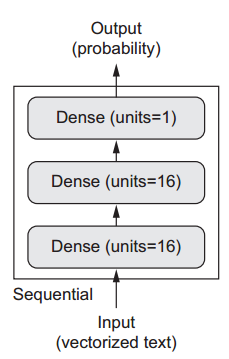

### The model definition

In [20]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Finally, you need to choose a loss function and an optimizer. 
Because you’re facing a binary classification problem and the output of your network is a probability (you end your network with a single-unit layer with a sigmoid activation), it’s best to use the *binary_crossentropy* loss. It isn’t the only viable choice: you could use, for instance, *mean_squared_error*. 

But crossentropy is usually the best choice when you’re dealing with models that output probabilities. **Crossentropy** is a quantity from the field of Information Theory that measures the distance between probability distributions or, in this case, between the ground-truth distribution and your predictions.

#### Compiling the model

In [21]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['accuracy'])

##### Configuring the optimizer

Sometimes you may want to configure the parameters of your optimizer or pass a custom loss function or metric function. The former can be done by passing an *optimizer* class instance as the optimizer argument

In [22]:
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
loss='binary_crossentropy',
metrics=['accuracy'])

##### Using custom losses and metrics

In [23]:
from keras import losses
from keras import metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
loss=losses.binary_crossentropy,
metrics=[metrics.binary_accuracy])

#### Validating your approach

In order to monitor during training the accuracy of the model on data it has never seen before, you’ll create a *validation set* by setting apart 10,000 samples from the original training data.

In [24]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

You’ll now train the model for 20 epochs (20 iterations over all samples in the x_train and y_train tensors), in mini-batches of 512 samples. At the same time,
you’ll monitor loss and accuracy on the 10,000 samples that you set apart. 
You do so by passing the validation data as the validation_data argument.

In [25]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 4s 263us/step - loss: 0.5084 - acc: 0.7813 - val_loss: 0.3797 - val_acc: 0.8684
Epoch 2/20
15000/15000 [==============================] - 3s 183us/step - loss: 0.3004 - acc: 0.9047 - val_loss: 0.3004 - val_acc: 0.8897
Epoch 3/20
15000/15000 [==============================] - 3s 184us/step - loss: 0.2179 - acc: 0.9285 - val_loss: 0.3085 - val_acc: 0.8711
Epoch 4/20
15000/15000 [==============================] - 3s 184us/step - loss: 0.1750 - acc: 0.9437 - val_loss: 0.2840 - val_acc: 0.8832
Epoch 5/20
15000/15000 [==============================] - 3s 186us/step - loss: 0.1427 - acc: 0.9543 - val_loss: 0.2841 - val_acc: 0.8872
Epoch 6/20
15000/15000 [==============================] - 3s 186us/step - loss: 0.1150 - acc: 0.9650 - val_loss: 0.3166 - val_acc: 0.8772
Epoch 7/20
15000/15000 [==============================] - 3s 183us/step - loss: 0.0980 - acc: 0.9705 - val_loss: 0.3127 - 

On CPU, this will take less than 2 seconds per epoch—training is over in 20 seconds.

At the end of every epoch, there is a slight pause as the model computes its loss and accuracy on the 10,000 samples of the **validation data**.

Note that the call to *model.fit()* returns a **History** object which is a dictionary containing data about everything that happened during training. Let’s look at it:

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

The dictionary contains four entries: one per metric that was being monitored during training and during validation.

#### Plotting the training and validation loss

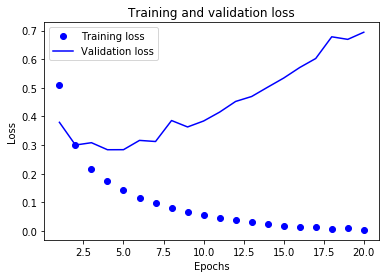

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Plotting the training and validation accuracy

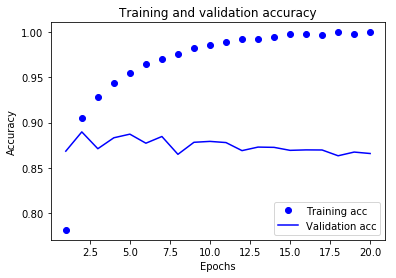

In [34]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As you can see, the training loss decreases with every epoch, and the training accuracy
increases with every epoch. That’s what you would expect when running gradientdescent optimization—the quantity you’re trying to minimize should be less with
every iteration. But that isn’t the case for the validation loss and accuracy: they seem to
peak at the fourth epoch. This is an example of what we warned against earlier: a
model that performs better on the training data isn’t necessarily a model that will do
better on data it has never seen before. In precise terms, what you’re seeing is overfitting: after the second epoch, you’re overoptimizing on the training data, and you end
up learning representations that are specific to the training data and don’t generalize
to data outside of the training set.
In this case, to prevent overfitting, you could stop training after three epochs. 

To prevent overfitting, you could stop training after three epochs.

Let’s train a new network from scratch for four epochs and then evaluate it on the test data.

In [35]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 3s 139us/step - loss: 0.4749 - acc: 0.8217
Epoch 2/4
25000/25000 [==============================] - 3s 125us/step - loss: 0.2658 - acc: 0.9097
Epoch 3/4
25000/25000 [==============================] - 3s 123us/step - loss: 0.1983 - acc: 0.9297
Epoch 4/4
25000/25000 [==============================] - 4s 150us/step


In [38]:
results

[0.32427601030349734, 0.87307999999999997]

#### Using a trained network to generate predictions on new data

In [39]:
model.predict(x_test)

array([[ 0.13804582],
       [ 0.99970043],
       [ 0.29756594],
       ..., 
       [ 0.07157168],
       [ 0.04313011],
       [ 0.47752824]], dtype=float32)

#### Further experiments

* You used two hidden layers. Try using one or three hidden layers, and see how doing so affects validation and test accuracy.

* Try using layers with more hidden units or fewer hidden units: 32 units, 64 units, and so on.

* Try using the mse loss function instead of binary_crossentropy.

* Try using the tanh activation (an activation that was popular in the early days of neural networks) instead of relu.

### Wrapping up

* You usually need to do quite a bit of preprocessing on your raw data in order to be able to feed it—as tensors—into a neural network. Sequences of words can be encoded as binary vectors, but there are other encoding options, too.

* Stacks of Dense layers with relu activations can solve a wide range of problems (including sentiment classification), and you’ll likely use them frequently.
* In a binary classification problem (two output classes), your network should end with a Dense layer with one unit and a sigmoid activation: the output of your network should be a scalar between 0 and 1, encoding a probability.

* With such a scalar sigmoid output on a binary classification problem, the loss function you should use is binary_crossentropy.

* The rmsprop optimizer is generally a good enough choice, whatever your problem. That’s one less thing for you to worry about.

* As they get better on their training data, neural networks eventually start overfitting and end up obtaining increasingly worse results on data they’ve never seen before. Be sure to always monitor performance on data that is outside of the training set.